In [26]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable, grad
from keras.utils.vis_utils import plot_model
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [27]:
# Root directory for dataset
dataroot = "abstract-art-gallery"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




In [28]:
!pip install opendatasets --upgrade --quiet

In [29]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/bryanb/abstract-art-gallery'
od.download(dataset_url)

Skipping, found downloaded files in "./abstract-art-gallery" (use force=True to force download)


In [30]:
import os
DATA_DIR = './abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery', 'Abstract_gallery_2']


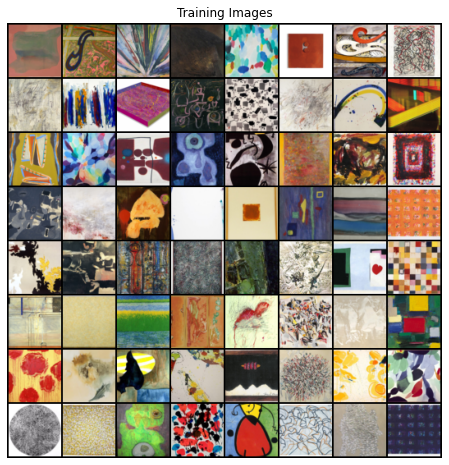

In [31]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [32]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [33]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [34]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


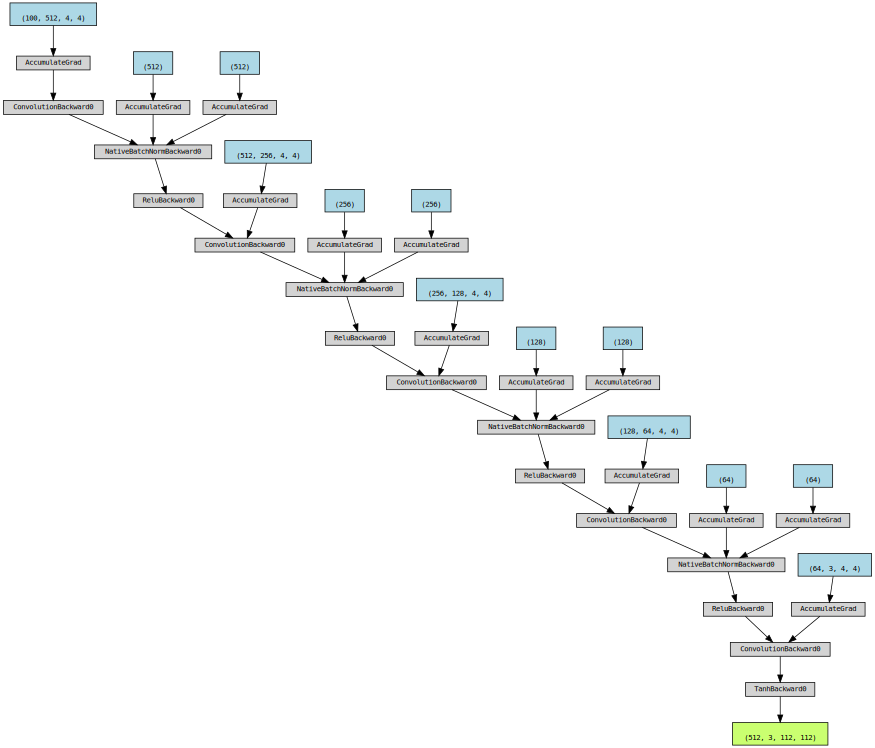

In [19]:
from torchviz import make_dot
x = torch.zeros(512,100, 4, 4, dtype=torch.float, requires_grad=False)
out = netG(x)
make_dot(out)  # plot graph of variable, not of a nn.Module

In [40]:
from torchsummary import summary
summary(netG, input_size=(100,4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 7, 7]         819,200
       BatchNorm2d-2            [-1, 512, 7, 7]           1,024
              ReLU-3            [-1, 512, 7, 7]               0
   ConvTranspose2d-4          [-1, 256, 14, 14]       2,097,152
       BatchNorm2d-5          [-1, 256, 14, 14]             512
              ReLU-6          [-1, 256, 14, 14]               0
   ConvTranspose2d-7          [-1, 128, 28, 28]         524,288
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
  ConvTranspose2d-10           [-1, 64, 56, 56]         131,072
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
  ConvTranspose2d-13          [-1, 3, 112, 112]           3,072
             Tanh-14          [-1, 3, 1

Discriminator Code



In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Flatten(),
            #nn.Linear(128, 1),
            #nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [42]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [46]:
from torchsummary import summary
summary(netD, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0
---------------------------

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
y_dim=64
X = Variable(torch.cuda.FloatTensor(batch_size,3,64,64))
print(X.shape)
z = Variable(torch.cuda.FloatTensor(batch_size, 100))
labels = Variable(torch.cuda.FloatTensor(batch_size))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

torch.Size([128, 3, 64, 64])


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 10
lambda_ = 5
print("Starting Training Loop...")
# For each epoch
for epoch in range(150):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        X = Variable(torch.cuda.FloatTensor(data[0].shape[0],3,64,64))
        X.data.copy_(data[0].to(device))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(X).view(-1)
        # Calculate loss on all-real batch
        #errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        #errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake = 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake

        # gradient penalty
        """
        alpha = torch.rand(data[0].shape[0], 3,64,64).to(device)
        x_hat = Variable(alpha * X.data + (1 - alpha) * (X.data + 0.5 * X.data.std() * torch.rand(X.size()).to(device)), requires_grad=True)
        pred_hat = netD(x_hat)
        gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).to(device),
                create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradient_penalty = lambda_ * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        gradient_penalty.backward()

        errD = errD_real + errD_fake+ gradient_penalty
        """
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        #errG = criterion(output, label)
        # Calculate gradients for G
        errG = 0.5 * torch.mean((output - label)**2) # criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/23]	Loss_D: 1.7342	Loss_G: 8.8778	D(x): 0.2659	D(G(z)): 0.5920 / -3.1791
[1/5][0/23]	Loss_D: 0.7931	Loss_G: 6.7096	D(x): 0.5067	D(G(z)): -0.3568 / -2.5849
[2/5][0/23]	Loss_D: 0.4808	Loss_G: 4.8939	D(x): 0.7338	D(G(z)): 0.4678 / -2.0722
[3/5][0/23]	Loss_D: 0.4311	Loss_G: 4.9621	D(x): 0.6211	D(G(z)): 0.3750 / -2.0984
[4/5][0/23]	Loss_D: 0.2902	Loss_G: 2.1507	D(x): 0.7422	D(G(z)): 0.2720 / -1.0421
[5/5][0/23]	Loss_D: 0.3682	Loss_G: 0.5796	D(x): 0.3937	D(G(z)): -0.0622 / -0.0162
[6/5][0/23]	Loss_D: 0.2817	Loss_G: 1.5253	D(x): 0.9204	D(G(z)): 0.5362 / -0.7068
[7/5][0/23]	Loss_D: 0.3174	Loss_G: 0.2851	D(x): 0.4389	D(G(z)): -0.2865 / 0.2866
[8/5][0/23]	Loss_D: 1.2024	Loss_G: 1.6108	D(x): 1.7014	D(G(z)): 1.2118 / -0.7223
[9/5][0/23]	Loss_D: 0.2553	Loss_G: 0.5202	D(x): 0.7903	D(G(z)): 0.4480 / 0.0497
[10/5][0/23]	Loss_D: 0.1592	Loss_G: 0.7447	D(x): 1.1216	D(G(z)): 0.3713 / -0.1985
[11/5][0/23]	Loss_D: 0.1613	Loss_G: 0.7364	D(x): 1.0492	D(G(z)): 0.2980 / -0.1750

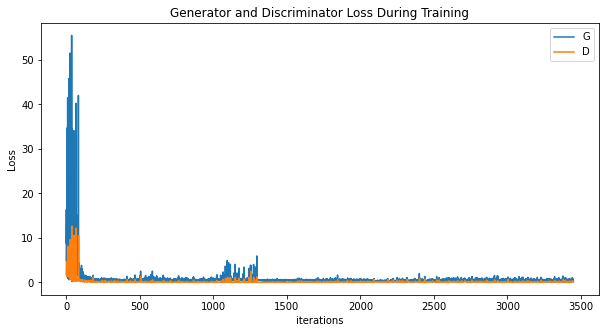

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

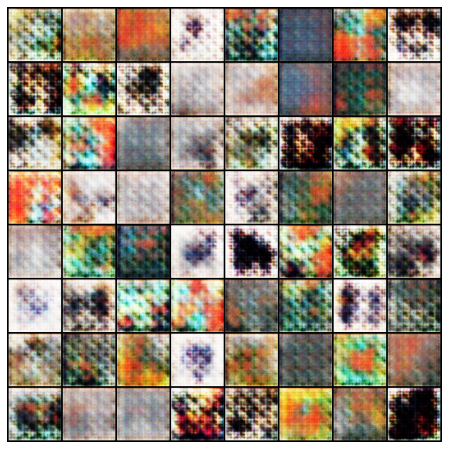

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




NameError: ignored

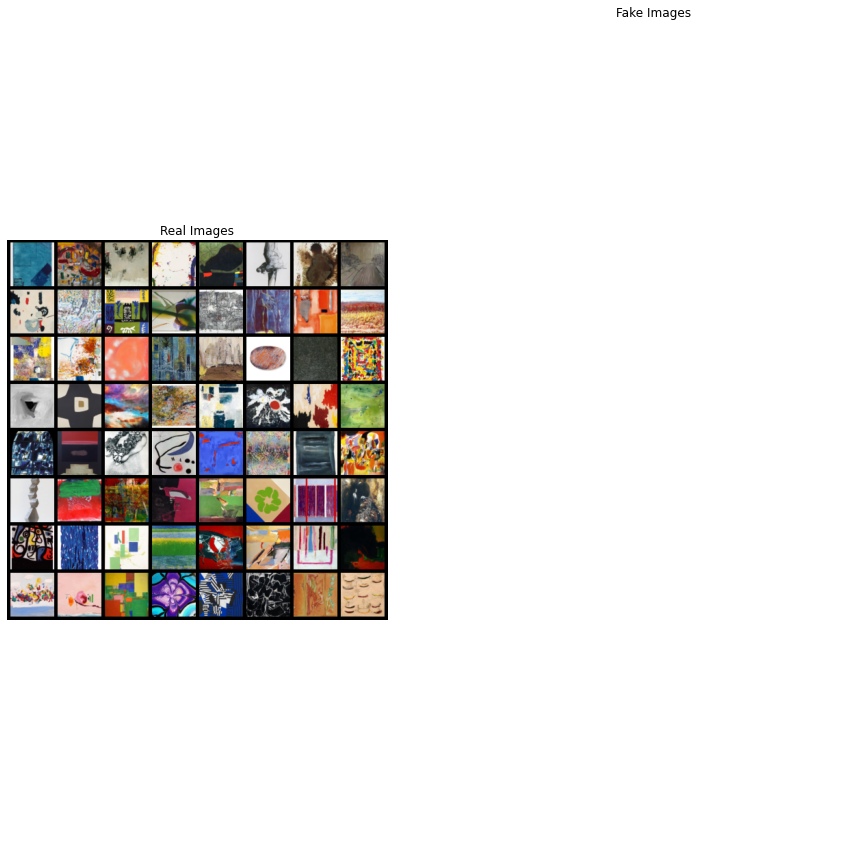

In [47]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()